## PRÁCTICA 2

En primer lugar, procedemos a cargar el dataset extraído de Kaggle, del link: https://www.kaggle.com/ionaskel/laptop-prices

In [367]:
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, shapiro, mannwhitneyu
from sklearn import preprocessing
from scipy import stats
import re
import statistics as st

laptops_file = 'https://raw.githubusercontent.com/carlosalloUOC/PRA2-Limpieza-Analisis/main/laptops.csv'
laptops_initial = pandas.read_csv(laptops_file, header=0, encoding='latin-1')
print(laptops_initial.shape)


(1303, 13)


TODO: Explicar que dimensiones coinciden

In [368]:
laptops_initial.head(5)

,Unnamed: 0,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


TODO: Explicar que se han cargado bien y explicación de cada campo

Eliminamos primera columna, al no aportar información y ser un simple id ascendente


In [369]:
del laptops_initial["Unnamed: 0"]
laptops_initial.head(5)

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


Se comprueba valores nulos, en un primer lugar por culumna

In [370]:
laptops_initial.isnull().sum()

Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64

Vemos como no hay ningún valor nulo. Para datasets con más columnas es más útil ver si hay algún valor nulo por medio del booleano, para que si este resulta verdadero, mirar dónde está el mismo

In [371]:
laptops_initial.isnull().values.any()


False

Es interesante realizar una limpieza de las variables para su posterior tratamiento en donde las variables que pueden ser consideradas como numéricas (Inches, Ram, Weight o Price_euros), sean tratadas así. Para el caso de Inches o Price_euros esto ya ocurre, pero para Ram o Weight no ocurre al aparecer sus unidades de medida como son GB o Kg. 

Aunque parece que en el dataSet todas las medidas están dadas en GB y Kg, lo primero que se realizará será ver si para todas las columnas se cumple este hecho. Comenzamos por la Ram:

In [372]:
#Se realiza un splitado en base a 'GB'
split_ram_value = laptops_initial['Ram'].str.split('GB', 0, expand=True)
#Se comprueba que todos los valores son numericos (no lo serían si hubiera otra medida)
split_ram_value[0].str.isnumeric().unique()

array([ True])

TODO: Siguiendo por el peso, y con el mismo procedimiento:

In [373]:
#Se realiza un splitado en base a 'kg'
split_weight_value = laptops_initial['Weight'].str.split('kg', 0, expand=True)

Una vez comprobado, se adaptan estas columnas con estos valores: 

In [374]:
laptops_initial=laptops_initial.rename(columns={'Ram': 'Ram(GB)', 'Weight': 'Weight(Kg)'})
laptops_initial["Ram(GB)"] = split_ram_value[0]
laptops_initial["Weight(Kg)"] = split_weight_value[0]
laptops_initial.head(5)

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram(GB),Memory,Gpu,OpSys,Weight(Kg),Price_euros
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,1339.69
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,898.94
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,575.00
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,2537.45
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1803.60


Ponemos de tipo numérico las columnas mencionadas

In [375]:
laptops_initial["Ram(GB)"] = pandas.to_numeric(laptops_initial["Ram(GB)"])
laptops_initial["Weight(Kg)"] = pandas.to_numeric(laptops_initial["Weight(Kg)"])
laptops_initial["Inches"] = pandas.to_numeric(laptops_initial["Inches"])
laptops_initial["Price_euros"] = pandas.to_numeric(laptops_initial["Price_euros"])
laptops_initial.head(5)

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram(GB),Memory,Gpu,OpSys,Weight(Kg),Price_euros
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,1339.69
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,898.94
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,575.00
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,2537.45
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1803.60


//TODO: Poner numerico por ejemplo el campo Memory (prestar atencion a unidad de medida y SSD o no)
//TODO: Separar CPU en 3 campos, ya que sigue estructura MARCA + PROCESADOR + VELOCIDAD

In [376]:
# Limpieza columna ScreenResolution (se dejan los valores que indican únicamente la resolución en píxeles)
laptops_initial["ScreenResolution"] = laptops_initial.ScreenResolution.str.extract("(\d+x\d+)", expand=False)
laptops_initial.ScreenResolution.isnull().sum()
laptops_initial.head(5)

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram(GB),Memory,Gpu,OpSys,Weight(Kg),Price_euros
0,Apple,MacBook Pro,Ultrabook,13.3,2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,1339.69
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,898.94
2,HP,250 G6,Notebook,15.6,1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,575.00
3,Apple,MacBook Pro,Ultrabook,15.4,2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,2537.45
4,Apple,MacBook Pro,Ultrabook,13.3,2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1803.60


In [377]:
# Limpieza columna Memory (se dejan los valores que indican únicamente la resolución en píxeles)
laptops_initial["Memory(Type)"] = laptops_initial.Memory.str.extract("^(\d+)(\w+).(SSD|HDD|Flash)", expand=False)[2]
laptops_initial["Memory"] = laptops_initial.Memory.str.extract("^(\d+)(\w+).(SSD|HDD|Flash)", expand=False)[0]

# Se convierte la variable Memory(GB) a tipo numérico
laptops_initial["Memory"] = pandas.to_numeric(laptops_initial["Memory"])

# Consideramos que los que tienen un valor inferior a 5 son TB y los convertimos a GB
laptops_initial.loc[laptops_initial['Memory'] <= 5, 'Memory'] = laptops_initial['Memory']*1000
laptops_initial.head(5)

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram(GB),Memory,Gpu,OpSys,Weight(Kg),Price_euros,Memory(Type)
0,Apple,MacBook Pro,Ultrabook,13.3,2560x1600,Intel Core i5 2.3GHz,8,128.0,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,SSD
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128.0,Intel HD Graphics 6000,macOS,1.34,898.94,Flash
2,HP,250 G6,Notebook,15.6,1920x1080,Intel Core i5 7200U 2.5GHz,8,256.0,Intel HD Graphics 620,No OS,1.86,575.00,SSD
3,Apple,MacBook Pro,Ultrabook,15.4,2880x1800,Intel Core i7 2.7GHz,16,512.0,AMD Radeon Pro 455,macOS,1.83,2537.45,SSD
4,Apple,MacBook Pro,Ultrabook,13.3,2560x1600,Intel Core i5 3.1GHz,8,256.0,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,SSD


# **4. Análisis de los datos**

## 4.1 Selección de los grupos de datos que se quieren analizar/comparar (planificación de los análisis a aplicar).

La variable objetivo de este conjunto de datos es la variable de Price_euros, debido a que en apartados posteriores, realizaremos un contraste de medias y un modelo de regresión lineal.

En el contraste de medias, estudiaremos si se puede afirmar que es estadísticamente significativo que los productos de Apple tengan un coste más elevado que el resto de marcas. 

En la regresión lineal, se realizará un modelo que trate de predecir el precio de un dispositivo teniendo en cuenta sus características técnicas. Para ello, se hará uso de las variables independientes que muestren tener más impacto en el cálculo final del producto, realizando un análisis de sus distribuciones y correlación.

## **Contraste de medias**

Tal y como se ha indicado anteriormente, procedemos en este apartado a realizar un constraste de medias que nos indicará si los productos de Apple son significativamente más caros, de media, que el resto de productos de otras marcas. 

Para ello, separaremos primero el dataset en dos de tal forma que contengan respectivamente los precios de los productos de Apple y del resto de marcas.

In [378]:
apple_prices = laptops_initial[laptops_initial["Company"] == "Apple"]["Price_euros"]
other_prices = laptops_initial[laptops_initial["Company"] != "Apple"]["Price_euros"]
print(apple_prices.head(5))
print(other_prices.head(5))

print(f'Precio medio de los productos de Apple: {round(st.mean(apple_prices), 2)}.')
print(f'Precio medio de los productos de otras marcas: {round(st.mean(other_prices), 2)}.')

0    1339.69
1     898.94
3    2537.45
4    1803.60
6    2139.97
Name: Price_euros, dtype: float64
2      575.0
5      400.0
8     1495.0
9      770.0
10     393.9
Name: Price_euros, dtype: float64
Precio medio de los productos de Apple: 1564.2.
Precio medio de los productos de otras marcas: 1116.47.


Una vez separadas las muestras, estudiamos la normalidad de cada una de ellas:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.8930661678314209, 0.025735169649124146)

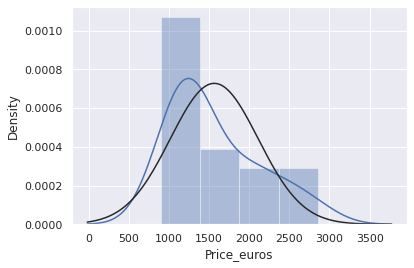

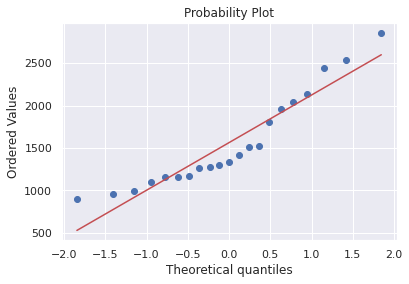

In [379]:
# Histograma y gráfico de probabilidad normal de los precios de Apple:

sns.distplot(apple_prices, fit = norm);
fig = plt.figure()
res = stats.probplot(apple_prices, plot = plt)

# Prueba de Shapiro-Wilk
stat, p = shapiro(apple_prices)
stat, p

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.8909043669700623, 3.601114643371191e-29)

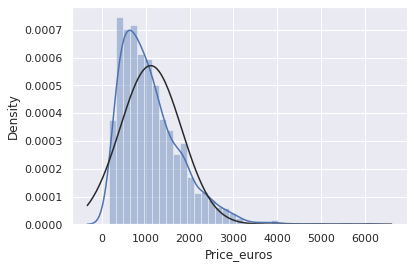

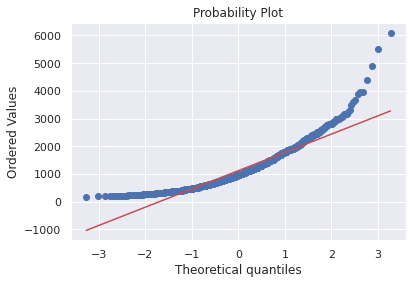

In [380]:
# Histograma y gráfico de probabilidad normal de los precios del resto de marcas:

sns.distplot(other_prices, fit = norm);
fig = plt.figure()
res = stats.probplot(other_prices, plot = plt)

# Prueba de Shapiro-Wilk
stat, p = shapiro(other_prices)
stat, p

En base a los resultados obtenidos, no es posible garantizar la normalidad en la distribución de las muestras de precios tanto de apple como de otras marcas dado que el test de Shapiro rechaza la hipótesis nula de normalidad. Asimismo, en el caso del subset de Apple, no sería posible tampoco aplicar el teorema del límite central al no superar las 30 muestras. 

En este sentido, para poder confirmar si podemos asumir homocedasticidad (igualdad de varianzas entre muestras) debemos aplicar el test de Fligner-Killeen (no paramétrico) al no poder suponer normalidad:

In [381]:
# Fligner-Killeen test
fligner_test = stats.fligner(apple_prices, other_prices, center='median')
fligner_test

FlignerResult(statistic=0.9821213321141975, pvalue=0.32167564402079707)

A raíz de los resultados (p value >> 0.05) no podemos descartar la hipótesis nula, por lo que se confirma la homocedasticidad. No obstante, debido a que no hemos podido afirmar que sigan distribuciones normales, no podremos aplicar un contraste de muestras paramétrico (t-Student), si no que tendremos que aplicar uno no paramétrico (Mann-Whitney):

In [382]:
# Mann-Whitney test
mannwhitneyu_test = stats.mannwhitneyu(apple_prices, other_prices, alternative="greater")
print(mannwhitneyu_test)

MannwhitneyuResult(statistic=19689.0, pvalue=0.00013581790526573893)


En base a los resultados obtenidos del test de Mann-Whitney (p value << 0.05), podemos rechazar la hipótesis nula en favor de la hipótesis alternativa que, en este caso, correspondía con que el precio de los productos de Apple es superior de media que para el resto de marcas.

**A partir de aquí los cálculos son provisionales y desordenados.... TODO: Modelo de regresión para predecir el precio de los productos a partir de las variables (hacer correlaciones y escoger mejores variables para despues aplicar al modelo)**

## **Relación con variables categóricas**

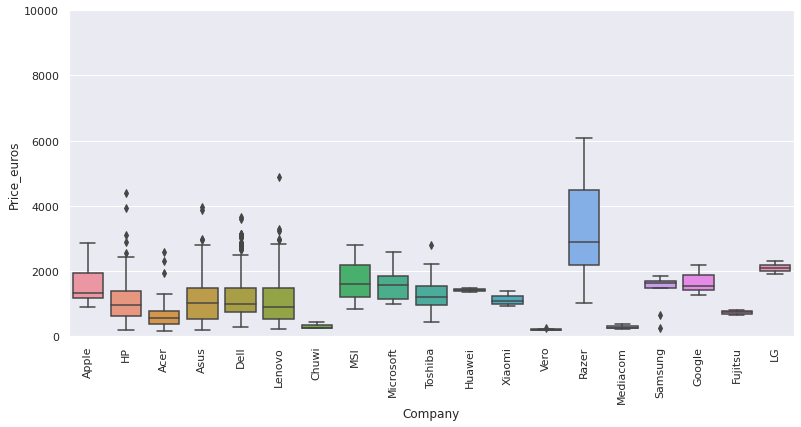

In [383]:
# Boxplot Company/Price_euros:

var = 'Company'
data = pandas.concat([laptops_initial['Price_euros'], laptops_initial[var]], axis=1)
f, ax = plt.subplots(figsize=(13, 6))
fig = sns.boxplot(x=var, y="Price_euros", data = data)
fig.axis(ymin=0, ymax=10000);
plt.xticks(rotation=90);

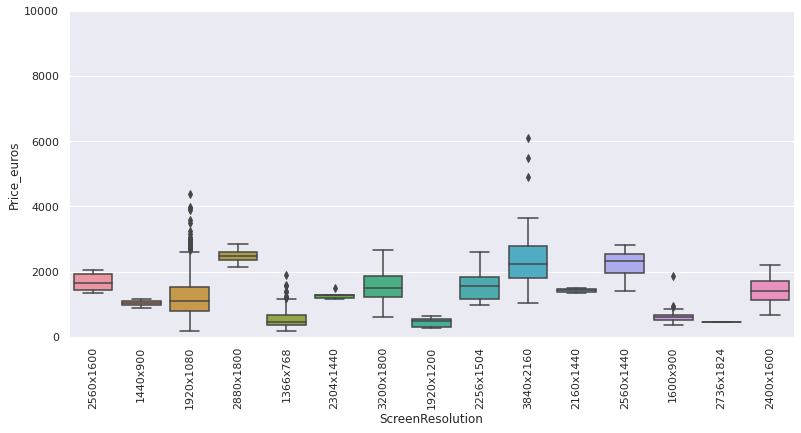

In [384]:
# Boxplot ScreenResolution/Price_euros:

var = 'ScreenResolution'
data = pandas.concat([laptops_initial['Price_euros'], laptops_initial[var]], axis=1)
f, ax = plt.subplots(figsize=(13, 6))
fig = sns.boxplot(x=var, y="Price_euros", data = data)
fig.axis(ymin=0, ymax=10000);
plt.xticks(rotation=90);

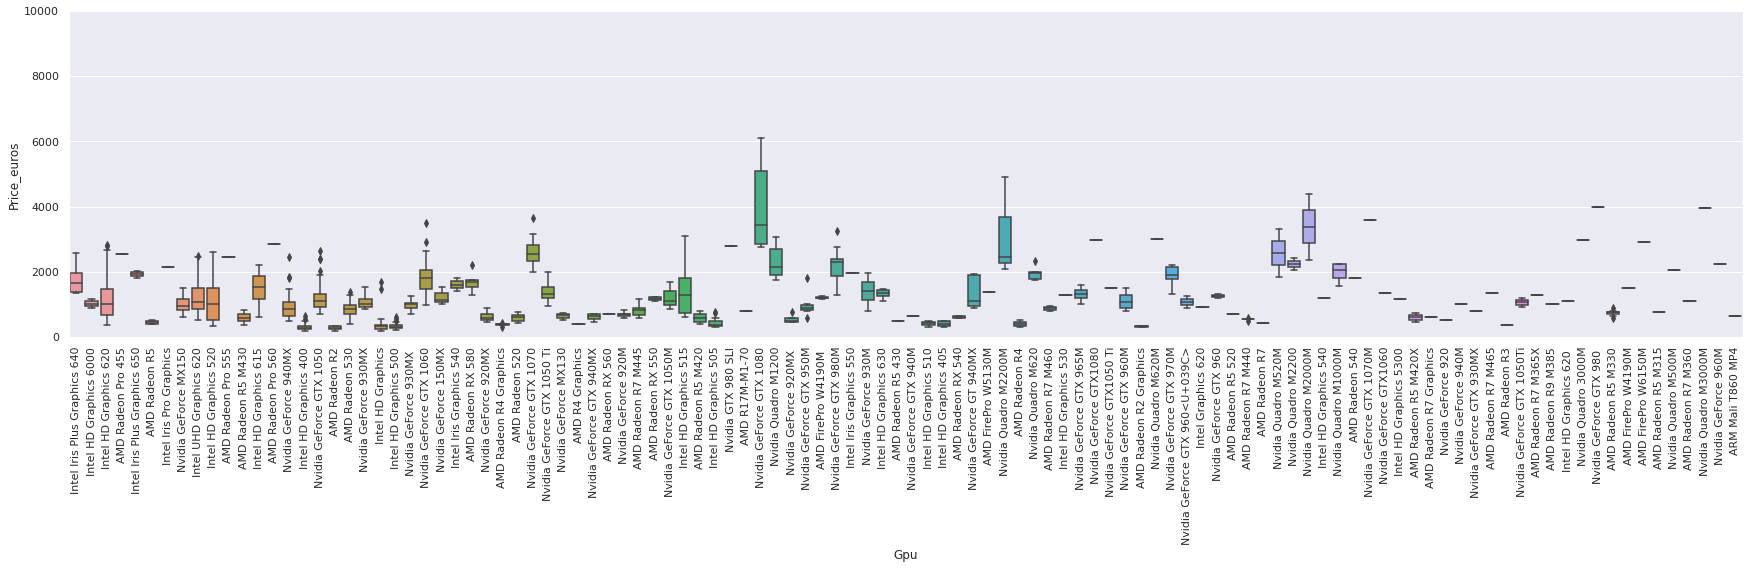

In [385]:
# Boxplot GPU/Price_euros:

var = 'Gpu'
data = pandas.concat([laptops_initial['Price_euros'], laptops_initial[var]], axis=1)
f, ax = plt.subplots(figsize=(30, 6))
fig = sns.boxplot(x=var, y="Price_euros", data = data)
fig.axis(ymin=0, ymax=10000);
plt.xticks(rotation=90);

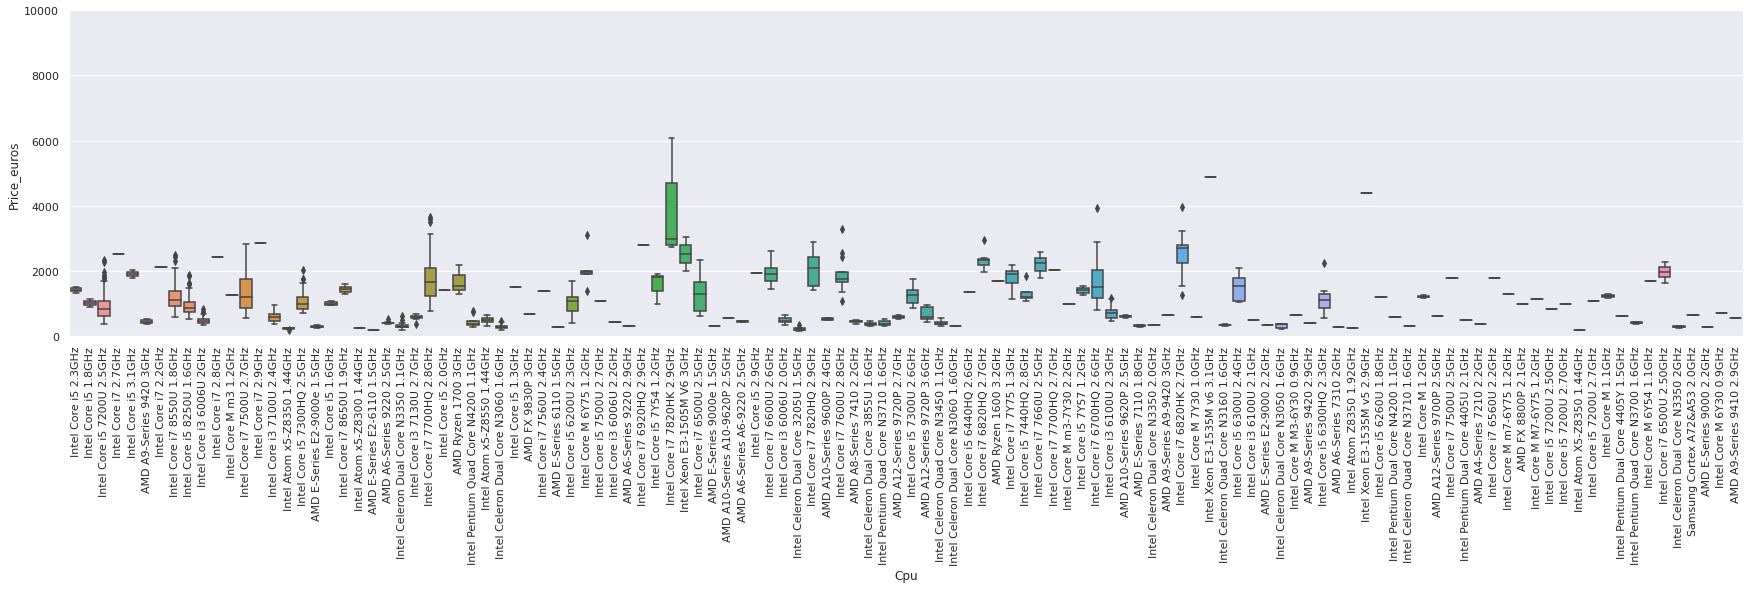

In [386]:
# Boxplot CPU/Price_euros:

var = 'Cpu'
data = pandas.concat([laptops_initial['Price_euros'], laptops_initial[var]], axis=1)
f, ax = plt.subplots(figsize=(30, 6))
fig = sns.boxplot(x=var, y="Price_euros", data = data)
fig.axis(ymin=0, ymax=10000);
plt.xticks(rotation=90);

Si bien vemos una diferencia de precios más marcada respecto a las GPU que usa cada dispositivo, también es apreciable una diferencia de precio dada por la marca del producto. 

En cuanto a marcas, destacan como las más caras Razer y LG y las más baratas Mediacom, Chuwi y Vero. En cuanto a GPU y CPU, son más caros los ordenadores que montan la Nvidia GeForce GTX 1080 y el Intel Core I7 7820HK 2.9GHz.

## **Relación con variables numéricas**

Realizamos primero una matriz de correlación, que nos podrá indicar con qué variables tiene más relación el valor del precio:

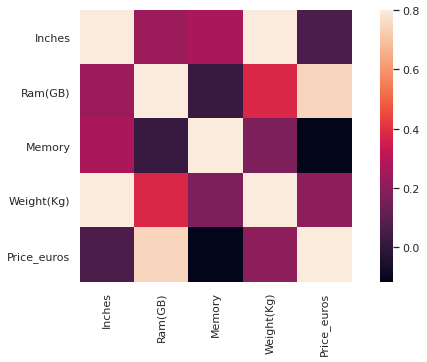

In [387]:
# Matriz de correlación:

corrmat = laptops_initial.corr()
f, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(corrmat, vmax=.8, square=True);

Tal y como se puede apreciar en el mapa de calor, la variable numérica con la que tiene más correlación el precio es con la cantidad de RAM que tenga el dispositivo.

A continuación graficamos los diagramas de dispersión de las variables numéricas para ver la relación que tienen con la variable del precio. 

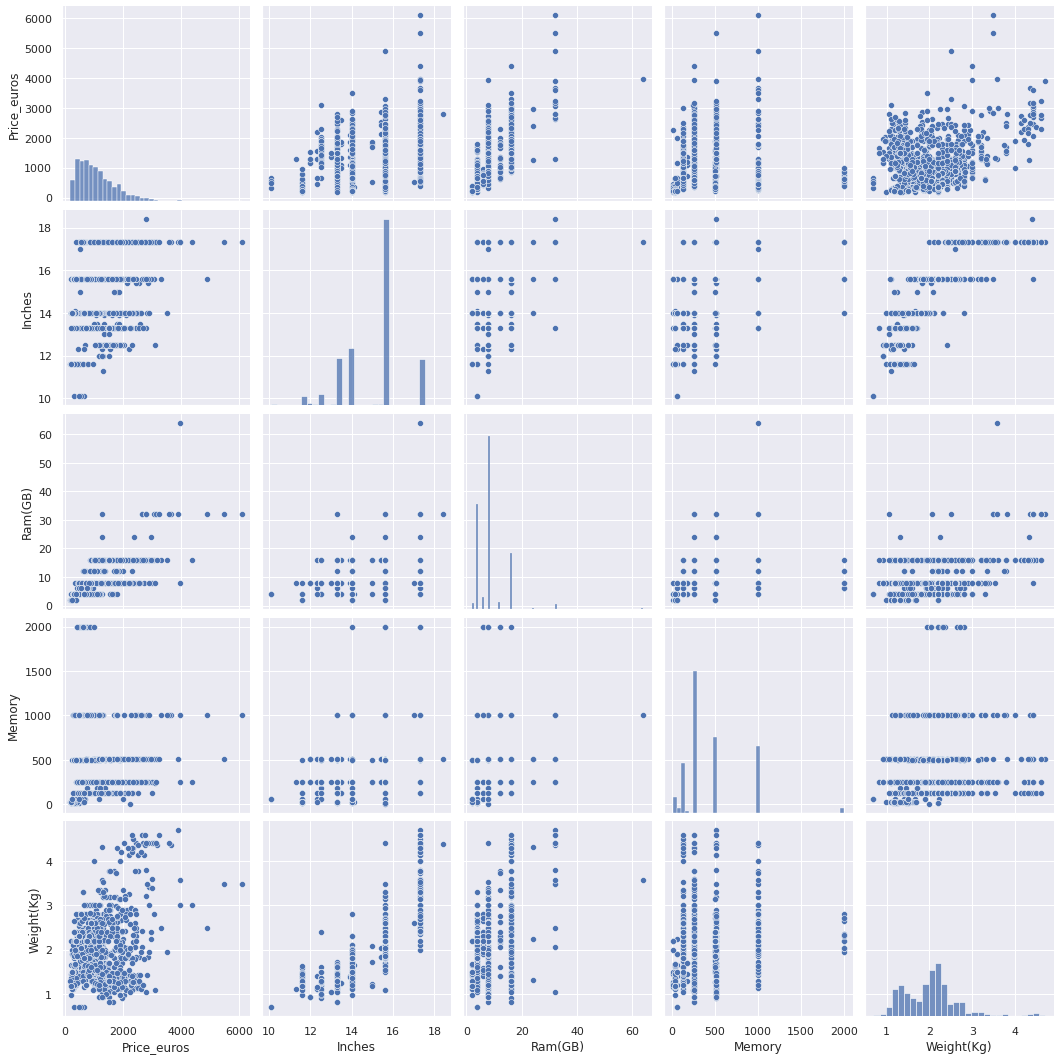

In [388]:
# Scatter plot:

sns.set()
cols = ['Price_euros', 'Inches', 'Ram(GB)', 'Memory', 'Weight(Kg)']
sns.pairplot(laptops_initial[cols], height = 3)
plt.show();